
# TP CNN, part 3 : super-resolution

Author : Alasdair Newson
alasdair.newson@telecom-paris.fr
 
## Objective:

We want to implement a Convolutional Neural Network (CNN) to do image super-resolution.

## Image super-resolution:

The super-resolution problem can be summarised as follows. We have an image as an input, which is defined over a grid $\{0,1,\dots, m-1\} \times \{0,1,\dots, n-1\}$. We define a factor $\delta$, by which we upsample the image. The output of the super-resolution is an image defined on the grid $\{0,\frac{1}{\delta},\dots, m-1\} \times \{0,\frac{1}{\delta},\dots, n-1\}$.

## Model

In this part of the TP, you have complete freedom to create any model you want, as long as the input is an image, and the output is also an image of size $\delta m \times \delta n$. You will have to choose the architecture and loss which seems reasonable to you.

To help you, here is a function to upsample images in neural networks :

- ```from tensorflow.keras.layers import UpSampling2D```

Of course, you can use any upsampling layer you wish. 

## Dataset

We will be using the mnist dataset for this part. This is to ensure that you can obtain good results. The input data should be the subsampled version of the mnist images, subsampled by taking one out of every $\delta$ pixels. The output data should be the normal-resolution mnist images.

__IMPORTANT NOTES:__
- Think carefully about what the training data and labels are in this case, and create them accordingly
- We will use ```n_max=5000``` to limit the number of datapoints (as in part 1) to go faster
- We set $\delta$ to 2 in this TP, because it is not too difficult to create a network that works with this factor. If you change it, it might be more difficult to create a satisfactory network.

# Your task:
You have to load the mnist data (see the first part of the TP), create the model, train it, and evaluate and display the results.

We have created a function ```super_res_interpolate```, which carries out super-resolution using basic interpolation (bilinear or bicubic), with which you can compare your results visually and numerically.



In [ ]:
# # Load packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input , Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D,Conv1D,MaxPool2D
from tensorflow.keras.layers import LeakyReLU,BatchNormalization
from tensorflow.keras import optimizers,regularizers
from scipy import interpolate
print(tf.keras.__version__)

2.6.0


This next cell is the only code you are given to carry out the TP. This function carries out a bilinear upsampling, with which you can compare your super-resolution. This function is __not__ supposed to be used by you in your network.

In [ ]:
# choice of the interpolation method
interp_method = 'linear'
# upsampling factor
delta = 2
# the maximum number of data to take from mnist (to go a bit faster)
n_max = 5000

# upsample by a factor of delta
# by definition, the new grid has a step size of 1/delta
def super_res_interpolate(imgs_in,delta,interp_method = 'linear'):
	imgs_out = tf.image.resize( tf.constant(imgs_in),\
		[delta*imgs_in.shape[1],delta*imgs_in.shape[2]], method='bilinear').numpy()

	return(imgs_out)


## Create your super-resolution network

The rest is up to you ! Import the data, format it (you can use the first part of the TP as help), create your network, train it, and compare the results with ```super_res_interpolate```.

Your network should be able to achieve about $80\%$ accuracy.

__Note__ you can obviously create as many cells as you like in your work.

## Loading data

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.take(n_max)

ds_test = ds_test.take( int(n_max*2/8) ) # 80-20 test

print('There are {} train data'.format(len(ds_train)))
print('There are {} test data'.format(len(ds_test)))

There are 5000 train data
There are 1250 test data


## Data preprocessing


Here we define two functions: 
- A function for normalization: Normalize the data
- A function for downsampling: generate a low resolution image from one that has a high resolution

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0


def downsampling(high_res, delta=2):
    low_res = high_res[::delta, ::delta, :]
    return low_res, high_res

Let's apply the function downsampling on our data set

In [ ]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(downsampling, num_parallel_calls=tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(downsampling, num_parallel_calls=tf.data.AUTOTUNE)

Now, let's look at some of the data befor and after downsampling:

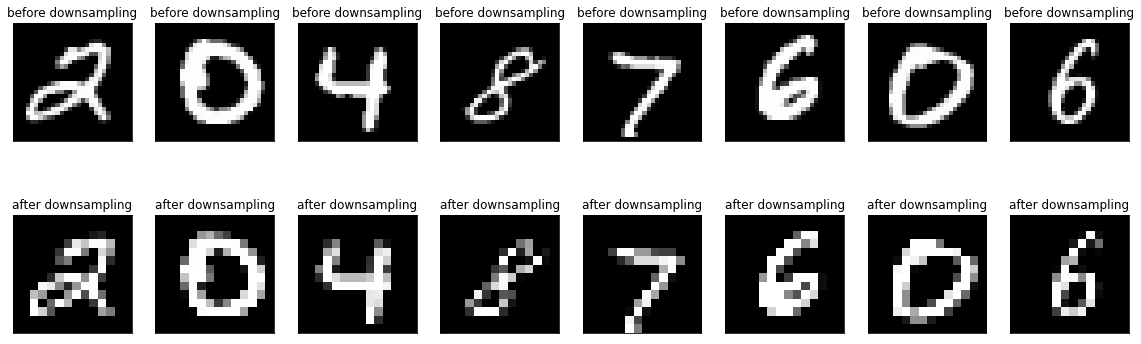

In [ ]:
n = 8
plt.figure(figsize= (20,10))
for i, (low_res,high_res) in enumerate(ds_test.take(n)):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(high_res[:,:,0],cmap='gray')
  plt.title("before downsampling")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(low_res[:,:,0],cmap='gray')
  plt.title("after downsampling")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Model Definition

This is the architecture of our model:

In [ ]:
Input_img = Input(shape=(14, 14, 1))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x_6_1 = Conv1D(128,1,1,padding='same')(x3)
x_6_2 = Add()([x_6_1, x5])
x6 = MaxPool2D(padding='same')(x_6_2)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = x9 
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = x13 
x15 = Conv2D(32, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
x16 = UpSampling2D()(x15)
x17 = Conv2D(16, (3, 3), padding='valid',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x16)
x18 = Conv2D(1, (3, 3), padding='valid',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x17)
model = Model(Input_img, x18)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 14, 14, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 7, 7, 64)     0           conv2d_13[0][0]                  
____________________________________________________________________________________________

# Training

We will first define some callbacks so that it would be easy for model visualization and evaluation in future.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint1.h5', save_best_only = True)

In [ ]:
BATCH_SIZE = 16
train_dataset_batched = ds_train.batch(BATCH_SIZE)
test_dataset_batched = ds_test.batch(BATCH_SIZE)

Let's train our model

In [ ]:
history = model.fit(train_dataset_batched,
            epochs=100,
            validation_data=test_dataset_batched,
            callbacks=[early_stopper, model_checkpoint],
            )

Epoch 1/100
313/313 [==============================] - 18s 28ms/step - loss: 0.0267 - accuracy: 0.8054 - val_loss: 0.0135 - val_accuracy: 0.8083
Epoch 2/100


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


313/313 [==============================] - 8s 25ms/step - loss: 0.0120 - accuracy: 0.8133 - val_loss: 0.0099 - val_accuracy: 0.8101
Epoch 3/100
313/313 [==============================] - 9s 27ms/step - loss: 0.0100 - accuracy: 0.8129 - val_loss: 0.0091 - val_accuracy: 0.8101
Epoch 4/100
313/313 [==============================] - 8s 25ms/step - loss: 0.0090 - accuracy: 0.8123 - val_loss: 0.0081 - val_accuracy: 0.8104
Epoch 5/100
313/313 [==============================] - 8s 25ms/step - loss: 0.0082 - accuracy: 0.8136 - val_loss: 0.0077 - val_accuracy: 0.8106
Epoch 6/100
313/313 [==============================] - 8s 24ms/step - loss: 0.0077 - accuracy: 0.8145 - val_loss: 0.0069 - val_accuracy: 0.8107
Epoch 7/100
313/313 [==============================] - 8s 25ms/step - loss: 0.0073 - accuracy: 0.8144 - val_loss: 0.0071 - val_accuracy: 0.8107
Epoch 8/100
313/313 [==============================] - 9s 27ms/step - loss: 0.0070 - accuracy: 0.8145 - val_loss: 0.0073 - val_accuracy: 0.8105
Epoc

## test

Now, let's evaluate our model (Super resolution neural network) on our test dataset:

In [ ]:
results = model.evaluate(test_dataset_batched)
print('Accuracy', results[1])

79/79 [==============================] - 1s 12ms/step - loss: 0.0062 - accuracy: 0.8106
Accuracy 0.8106438517570496


Then, let's evaluate the defined model (the bilinear interpolation) method on our test dataset:

In [ ]:
acc = tf.keras.metrics.Accuracy()
low_resolution_images = tf.stack([low_res for low_res,high_res in ds_test])
high_resolution_images = tf.stack([high_res for low_res,high_res in ds_test])

bilinear_resoltion_images = super_res_interpolate(low_resolution_images,delta=2)

acc.update_state(bilinear_resoltion_images,high_resolution_images)

print('Accuracy', acc.result().numpy())

Accuracy 0.67912346


As a result, we obtain as accuracy: 
- 67% for the bilinear interpolation
- 81% for the super resolution neural network (the model that we have defined)
So we notice that the learning increases and reaches around  81% 

Now, let's visualize the difference between the two methods: 

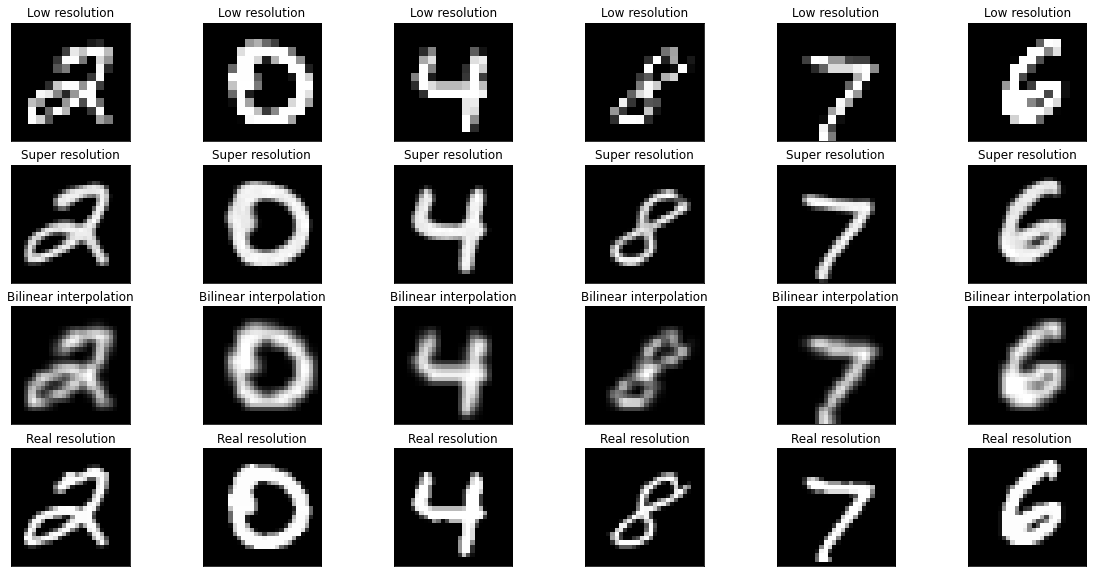

In [ ]:
test_dataset_batched = ds_test.batch(1)
n = 6
plt.figure(figsize= (20,10))
for i, (low_res,high_res) in enumerate(ds_test.take(n)):
  super_res = model.predict(tf.expand_dims(low_res,axis=0))[0]
  bilinear_res = super_res_interpolate(tf.expand_dims(low_res,axis=0),delta=2)[0]

#The input of low resolution images
  ax = plt.subplot(4, n, i+1)
  plt.imshow(low_res[:,:,0],cmap='gray')
  plt.title("Low resolution")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
#The result of our trained model (Super_resolution_network)
  ax = plt.subplot(4, n, i+1+n)
  plt.imshow(super_res[:,:,0],cmap='gray')
  plt.title("Super resolution")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

#The result of the Bilinear interpolation (super_res_interpolate)
  ax = plt.subplot(4, n, i+1+2*n)
  plt.imshow(bilinear_res[:,:,0],cmap='gray')
  plt.title("Bilinear interpolation")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
#The real images
  ax = plt.subplot(4, n, i+1+3*n)
  plt.imshow(high_res[:,:,0],cmap='gray')
  plt.title("Real resolution")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

# Evaluation

To evaluate the work, you should rate the code for 
- 1) Importing MNIST correctly (correctly formatting the data) : 1 point
- 2) Creating a model which makes sense (correct input/output sizes) : 1 point
- 3) Training and achieving good results  : 2 points. 1 point if the learning increases but does not reach around $80\%$, 2 points if the learning reaches around $80\%$
- 4) Display a visual comparison of your network with ```super_res_interpolate``` for several examples

Total over 5 points.
